# Tutorial - examples of all metrics

This notebook shows the functionality of the various metrics included in the library. 

For this purpose, we use a pre-trained ResNet-18 model and Pascal-VOC 2012 dataset.

Descriptions for how to download the dataset can be found here: https://image-net.org/download.php.

In [1]:
# Mount Google Drive. #remove
from google.colab import drive 
drive.mount('/content/drive', force_remount=True)

# Install packages. #remove
!pip install captum opencv-python xmltodict
!pip install torch==1.8.0+cu111 torchvision==0.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html

# Imports general.
import sys
import warnings
import gc
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision
import captum
from torchvision import transforms
from tqdm import tqdm
from captum.attr import *
import random
import os
import PIL
from xml.etree import ElementTree
import xmltodict
import cv2
import collections

# Import package.
sys.path.append('/content/drive/MyDrive/Projects/xai_quantification_toolbox')
import quantus

# Notebook settings.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
warnings.filterwarnings("ignore", category=UserWarning)
%load_ext autoreload
%autoreload 2

# Collect garbage.
gc.collect()
torch.cuda.empty_cache()

Mounted at /content/drive
     |████████████████████████████████| 1.4 MB 30.6 MB/s 
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |█████████████▌                  | 834.1 MB 1.4 MB/s eta 0:13:54tcmalloc: large alloc 1147494400 bytes == 0x555d70276000 @  0x7efff3426615 0x555d374194cc 0x555d374f947a 0x555d3741c2ed 0x555d3750de1d 0x555d3748fe99 0x555d3748a9ee 0x555d3741dbda 0x555d3748fd00 0x555d3748a9ee 0x555d3741dbda 0x555d3748c737 0x555d3750ec66 0x555d3748bdaf 0x555d3750ec66 0x555d3748bdaf 0x555d3750ec66 0x555d3748bdaf 0x555d3741e039 0x555d37461409 0x555d3741cc52 0x555d3748fc25 0x555d3748a9ee 0x555d3741dbda 0x555d3748c737 0x555d3748a9ee 0x555d3741dbda 0x555d3748b915 0x555d3741dafa 0x555d3748bc0d 0x555d3748a9ee
     |█████████████████               | 1055.7 MB 1.4 MB/s eta 0:10:41tcmalloc: large alloc 1434370048 bytes == 0x555db48cc000 @  0x7efff3426615 0x555d374194cc 0x555d374f947a 0x555d3741c2ed 0x555d3750de1d 0x555d3748fe99 0x555d3748a9ee 0x555d3741dbda 0x5

## Preliminaries

### Load datasets

We will then load a batch of input, output pairs that we generate explanations for, then to evaluate.

In [64]:
# For the localisation metrics we need to load a dataset that has ground truth masks.

def load_sample(path: str) -> dict:
    """ Reads data as image and path. """
    return {"data": PIL.Image.open(path).convert("RGB"), "path": path}

def load_binary_mask(filename: str, path_data: str):
    """ Loads the binary mask for the given filepath in the correct format. """
    binary_mask = {}
    
    filename = os.path.splitext(filename)[0]
    
    # get label and file name
    label = filename.split("/")[-2]
    fname = filename.split("_")[-1]

    # parse annotations
    tree = ElementTree.parse(os.path.join(path_data, "Annotation/{}/{}_{}.xml".format(label, label, fname)))
    xml_data = tree.getroot()
    xmlstr = ElementTree.tostring(xml_data, encoding="utf-8", method="xml")
    annotation = dict(xmltodict.parse(xmlstr))['annotation']

    width = int(annotation["size"]["width"])
    height = int(annotation["size"]["height"])

    # iterate objects
    objects = annotation["object"]

    if type(objects) != list:
        mask = np.zeros((height, width), dtype=int)

        mask[int(objects['bndbox']['ymin']):int(objects['bndbox']['ymax']), int(objects['bndbox']['xmin']):int(objects['bndbox']['xmax'])] = 1

        binary_mask[objects['name']] = mask

    else:
        for object in annotation['object']:
            if type(object) == collections.OrderedDict:
                if object['name'] in binary_mask.keys():
                    mask = binary_mask[object['name']]
                else:
                    mask = np.zeros((height, width), dtype=np.uint8)

                mask[int(object['bndbox']['ymin']):int(object['bndbox']['ymax']),
                     int(object['bndbox']['xmin']):int(object['bndbox']['xmax'])] = 1

                binary_mask[object['name']] = mask

    # preprocess binary masks to fit shape of image data
    for key in binary_mask.keys():
        binary_mask[key] = cv2.resize(binary_mask[key],
                                      (224, 224),
                                      interpolation=cv2.INTER_NEAREST).astype(np.int)[:, :, np.newaxis]

    return binary_mask


class CustomTransform(torch.nn.Module):
    """Custom transformation to handle image processing and binary mask processing simultaneously. """
    
    image_transform = transforms.Compose([transforms.Resize((224, 224)),
                                          transforms.ToTensor(),
                                          transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
    def __init__(self, path_data):
        super().__init__()
        self.path_data = path_data
        
    def __call__(self, img):
        return {"data": self.image_transform(img["data"]), "mask": load_binary_mask(img["path"], self.path_data)}
    
def CustomCollate(batch):
    """ Collate function to pack the image, mask and label data accordingly. """
    #return np.array([mask_dict[list(mask_dict.keys())[0]][:, :, 0] for mask_dict in [dp[0]["mask"] for dp in batch]])
    x = []
    y = []
    mask = []
    
    for dp in batch:
        x.append(dp[0]["data"])
        mask.append(dp[0]["mask"])
        y.append(dp[1])
    
    return (torch.stack(x, 0), torch.Tensor(np.array([mask_dict[list(mask_dict.keys())[0]][:, :, 0] for mask_dict in mask]))), torch.tensor(y)


In [69]:
# Load test data and make loaders.
path_data = 'drive/MyDrive/Projects/xai_quantification_toolbox/tutorials/assets/imagenet_images/'
dataset = torchvision.datasets.DatasetFolder(os.path.join(path_data, "bboxes_images/"), 
                                   loader=load_sample, 
                                   extensions=(".jpeg", "png"),
                                   transform=CustomTransform(path_data))

test_loader = torch.utils.data.DataLoader(dataset, shuffle=True, batch_size=24, collate_fn=CustomCollate)

# Load a batch of inputs, segmentation masks and outputs to use for evaluation.
(x_batch, s_batch), y_batch = iter(test_loader).next()
x_batch, s_batch, y_batch = x_batch.to(device), s_batch.to(device), y_batch.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


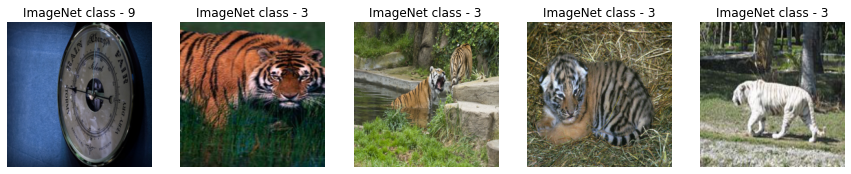

In [70]:
# Plot some inputs!

nr_images = 5
fig, axes = plt.subplots(nrows=1, ncols=nr_images, figsize=(nr_images*3, int(nr_images*2/3)))
for i in range(nr_images):
    axes[i].imshow(np.moveaxis(quantus.denormalize_image(x_batch[i].cpu().numpy()), 0, -1), vmin=0.0, vmax=1.0, cmap="gray")
    axes[i].title.set_text(f"ImageNet class - {y_batch[i].item()}")
    axes[i].axis("off")
plt.show()

### Load a torch model

In this example we load a pre-trained ResNet-18 model but it goes without saying that any model works.

In [71]:
def evaluate_model(model, data, device):
    """Evaluate accuracy of torch model."""
    model.eval()
    logits = torch.Tensor().to(device)
    targets = torch.LongTensor().to(device)

    with torch.no_grad():
        for images, labels in data:
            images, labels = images.to(device), labels.to(device)
            logits = torch.cat([logits, model(images)])
            targets = torch.cat([targets, labels])
            
    return np.mean(np.argmax(logits.cpu().numpy(), axis=1) == targets.cpu().numpy())
    
# Load pre-trained ResNet18 model.
model = torchvision.models.resnet18(pretrained=True)
model = model.to(device)

# Evaluate model performance.
#print(f"\nModel test accuracy: {(100 * evaluate_model(model.to(device), test_loader, device)):.2f}%")

### Generate attribution-based explanations

There exist multiple ways to generate explanations for neural network models e.g., using `captum` or `innvestigate` libraries. In this example, we rely on the `quantus.explain` functionality (a simple wrapper around `captum`) however use whatever approach or library you'd like to create your explanations.

**Requirements.**

* **Data type.** Similar to the x-y pairs, the attributions should also be of type `np.ndarray`
* **Shape.** Sharing all the same dimensions as the input (expect for nr_channels which for explanations is equal to 1). For example, if x_batch is of size (128, 3, 224, 224) then the attributions should be of size (128, 1, 224, 224).

In [72]:
# Generate Integrated Gradients attributions of the first batch of the test set.
a_batch = quantus.explain(model, x_batch, y_batch, method="IntegratedGradients")

# Save x_batch and y_batch as numpy arrays that will be used to call metric instances.
x_batch, s_batch, y_batch = x_batch.cpu().numpy(), s_batch.cpu().numpy(), y_batch.cpu().numpy()

# Make sure s_batch is of correct shape.
s_batch = s_batch.reshape(24, 1, 224, 224)

# Quick assert.
assert [isinstance(obj, np.ndarray) for obj in [x_batch, y_batch, s_batch, a_batch]]

Visulize attributions given model and input-output *pairs*.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


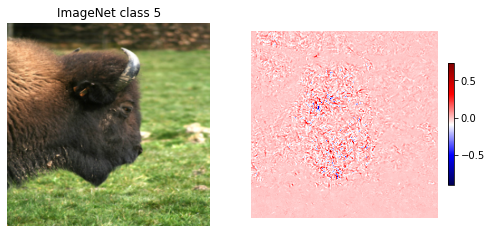

In [42]:
index = random.randint(0, len(x_batch)-1)

# Plot examplary explanations!
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 5))
axes[0].imshow(np.moveaxis(quantus.denormalize_image(x_batch[index], **{"img_size": 224}), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"ImageNet class {y_batch[index].item()}")
exp = axes[1].imshow(a_batch[index], cmap="seismic") 
fig.colorbar(exp, fraction=0.03, pad=0.05); 
axes[0].axis("off"); axes[1].axis("off"); plt.show()

## Evaluation using `quantus`

As a preliminary step to evaluating the explanations using all the available metrics in the library, we will first view what categories and metrics we have available.

In [43]:
# Let's view what metrics categories are available.
quantus.available_categories()

['Faithfulness',
 'Robustness',
 'Localisation',
 'Complexity',
 'Randomisation',
 'Axiomatic']

In [44]:
# In each category, let's view the available metrics.
metrics = quantus.available_metrics()
metrics

{'Axiomatic': ['Completeness Test',
  'Symmetry',
  'InputInvariance',
  'NonSensitivity',
  'Dummy'],
 'Complexity': ['Sparseness Test', 'Complexity Test', 'Effective Complexity'],
 'Faithfulness': ['Faithfulness Correlation',
  'Faithfulness Estimate',
  'Pixel-Flipping',
  'Region Segmentation',
  'Monotonicity Arya',
  'Monotonicity Nguyen',
  'Infidelity',
  'Selectivity',
  'SensitivityN',
  'IROF'],
 'Localisation': ['Pointing Game',
  'TKI',
  'Relevance Mass Accuracy',
  'Relevance Mass Ranking',
  'Attribution Localization '],
 'Randomisation': ['Model Parameter Randomisation Test', 'Random Logit Test'],
 'Robustness': ['Continuity Test',
  'Input Independence Rate',
  'Local Lipschitz Estimate',
  'Max-Sensitivity',
  'Avg-Sensitivity']}

#### Faithfulness metrics 

Score explanations using the following faithfulness metrics:

* Faithfulness Correlation (Bhatt et al., 2020)
* Faithfulness Estimate (Alvarez-Melis et al., 2018, 2019)
* Pixel-Flipping (Bach et al., 2015)
* Region Segmentation (Samek et al., 2015)
* Monotonicity-Arya (Arya et al., 2019)
* Monotonicity-Nguyen (Nguyen et al., 2019)
* Infidelity (Yeh et al., 2010)
* Selectivity (Montavan et al., 2018)
* SensitivityN (Ancona et al., 2018)
* IROF (Rieger et al., 2020)

In [45]:
# Return faithfulness correlation scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessCorrelation(**{
    "nr_runs": 100,  
    "subset_size": 224,  
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,    
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[0.007500860266464969]

In [ ]:
# Return faithfulness estimate scores in an one-liner - by calling the metric instance.
quantus.FaithfulnessEstimate(**{
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_pearson,
    "img_size": 224,  
    "features_in_step": 224,  
    "perturb_baseline": "black",  
    "pixels_in_step": 28,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[0.4397507023459257,
 0.2846298060977368,
 0.14146804591863815,
 0.600360279884552,
 0.09898214649211129,
 0.7212544803159102,
 0.577622007154587,
 -0.11283705771966282,
 -0.118761489003787,
 -0.26126109091790717,
 0.4508179339378905,
 0.7598147085121885,
 0.5247806839925868,
 0.2859959159276927,
 0.004335496792618243,
 0.19806891806795218,
 -0.22841375997423868,
 -0.17413005747131746,
 0.275014247621297,
 0.1350962298374841,
 0.4521700720956351,
 0.41774459482873694,
 -0.015601521164436256,
 0.5932739555506286]

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityArya(**{
    "features_in_step": 224,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
# Return monotonicity scores in an one-liner - by calling the metric instance.
quantus.MonotonicityNguyen(**{
    "nr_samples": 10,
    "features_in_step": 3136,
    "perturb_baseline": "uniform",
    "perturb_func": quantus.baseline_replacement_by_indices,
    "similarity_func": quantus.correlation_spearman,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})

[0.17352941176470588,
 -0.12058823529411765,
 0.6647058823529411,
 0.6323529411764706,
 -0.17058823529411765,
 0.3735294117647059,
 -0.21470588235294116,
 0.3205882352941176,
 -0.07941176470588236,
 0.22058823529411767,
 0.01764705882352941,
 0.0411764705882353,
 0.5058823529411764,
 0.08823529411764705,
 -0.19411764705882353,
 -0.07941176470588236,
 0.31176470588235294,
 0.21176470588235297,
 0.014705882352941175,
 0.2676470588235294,
 0.3588235294117647,
 0.25588235294117645,
 -0.45,
 0.5411764705882353]

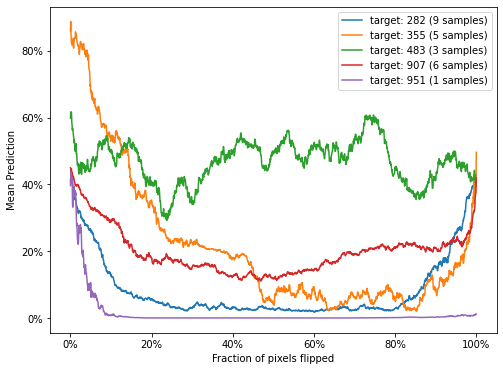

In [ ]:
# Create the pixel-flipping experiment.
pixel_flipping = quantus.PixelFlipping(**{
    "features_in_step": 28,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})
    
# Call the metric instance to produce scores.
scores = pixel_flipping(model=model,
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=a_batch,
                        **{"device": device})

# Plot example!
pixel_flipping.plot(y_batch=y_batch, scores=scores)

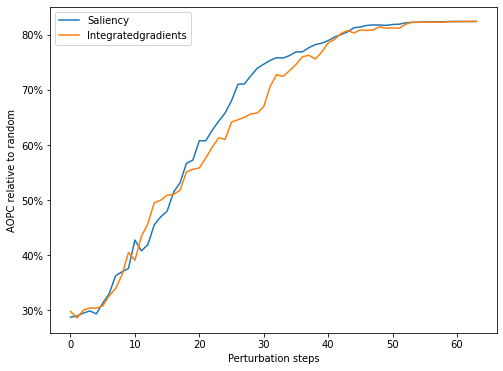

In [ ]:
# Create the region perturbation experiment.
region_perturb = quantus.RegionPerturbation(**{
    "patch_size": 28,
    "regions_evaluation": 100,
    "img_size": 224,
    "random_order": False,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "uniform",  
})
    
# Call the metric instance to produce scores.
results = {method: region_perturb(model=model, 
                                  x_batch=x_batch,
                                  y_batch=y_batch,
                                  a_batch=None,
                                  **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
region_perturb.plot(results=results)

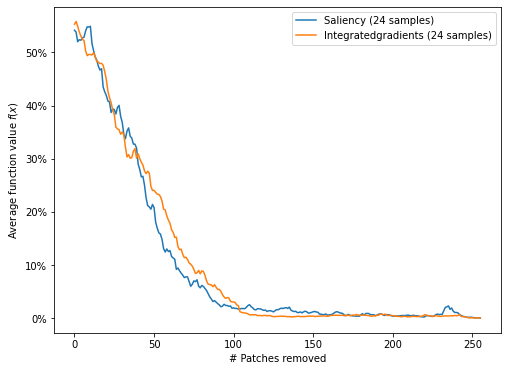

In [ ]:
# Create the selectivity experiment.
selectivity = quantus.Selectivity(**{
    "patch_size": 14,
    "perturb_func": quantus.baseline_replacement_by_patch,
    "perturb_baseline": "black",  
})
    
# Call the metric instance to produce scores.
results = {method: selectivity(model=model, 
                               x_batch=x_batch,
                               y_batch=y_batch,
                               a_batch=None,
                               **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Saliency", "IntegratedGradients"]}

# Plot example!
selectivity.plot(results=results)

No handles with labels found to put in legend.


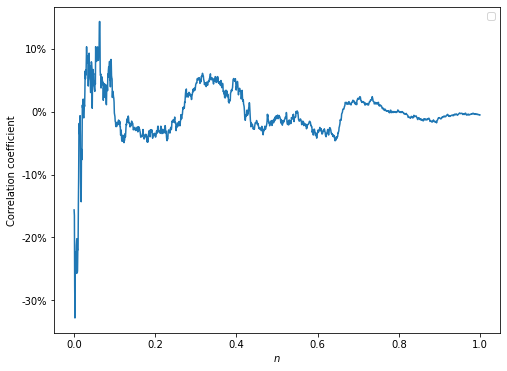

In [ ]:
# Create the sensitivity-n experiment.
sensitivity_n = quantus.SensitivityN(**{
    "features_in_step": 28,
    "n_max_percentage": 0.8,
    "img_size": 224,
    "similarity_func": quantus.correlation_pearson,
    "perturb_func": quantus.baseline_replacement_by_indices,
    "perturb_baseline": "uniform",  
})
# Call the metric instance to produce scores.
results = sensitivity_n(model=model, 
                        x_batch=x_batch,
                        y_batch=y_batch,
                        a_batch=None,
                        **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

# Plot example!
sensitivity_n.plot(results=results)

# TODO. The curves looks different than in paper?

In [ ]:
# Return IFOF scores in an one-liner - by calling the metric instance.
results = {method: quantus.IROF(**{
    "segmentation_method": "slic",
    "perturb_baseline": "mean",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model,
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": method, "device": device}) for method in ["Gradient", "Saliency", "IntegratedGradients", "GradientShap"]}

results

{'Gradient': [56.97762036085902],
 'GradientShap': [56.98805259109221],
 'IntegratedGradients': [56.98634842123121],
 'Saliency': [56.963678817307624]}

In [ ]:
# TODO. Verify implementation with captum.
'''
# Return infidelity scores in an one-liner - by calling the metric instance.
quantus.Infidelity(**{
    "loss_func": quantus.mse,
    "img_size": 224,
    "perturb_patch_sizes": [8, 14, 28],
    "perturb_baseline": "black",  
    "perturb_func": quantus.baseline_replacement_ (_patch,
})(model=model, 
   x_batch=x_batch, 
   y_batch=y_batch,
   a_batch=a_batch,
   **{"device": device})
''';

#### Robustness metrics 

Score explanations using the following robustness metrics:

* Local Lipschitz Estimate (Alvarez-Melis et al., 2018; 2019)
* Max-Sensitivity (Yeh at el., 2019)
* Avg-Sensitivity (Yeh at el., 2019)
* Continuity (Montavan et al., 2017)
* Input Independence Rate (Yang et al., 2019)

In [ ]:
# Return local lipschitzEstimate estimate scores in an one-liner - by calling the metric instance.
quantus.LocalLipschitzEstimate(**{
    "nr_samples": 10,
    "perturb_std": 0.1,
    "norm_numerator": quantus.distance_euclidean,
    "norm_denominator": quantus.distance_euclidean,
    "explain_func": quantus.explain,
    "perturb_func": quantus.gaussian_noise,
    "similarity_func": quantus.lipschitz_constant,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

In [ ]:
# Return max sensitivity scores in an one-liner - by calling the metric instance.
quantus.MaxSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

In [ ]:
# Return avg sensitivity scores in an one-liner - by calling the metric instance.
quantus.AvgSensitivity(**{
    "nr_samples": 10,
    "perturb_radius": 0.2,
    "norm_numerator": quantus.fro_norm,
    "norm_denominator": quantus.fro_norm,
    "explain_func": quantus.explain,
    "perturb_func": quantus.uniform_sampling,
    "similarity_func": quantus.difference,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

[0.017828868702054024,
 0.05963929742574692,
 0.04421377182006836,
 0.016141977161169052,
 0.021119093522429466,
 0.05297933891415596,
 0.04147179424762726,
 0.06225193664431572,
 0.01863543689250946,
 0.029246002435684204,
 0.024779191240668297,
 0.01804058812558651,
 0.026470307260751724,
 0.03374655172228813,
 0.02835090085864067,
 0.01039061602205038,
 0.045434582978487015,
 0.02882593497633934,
 0.04047077149152756,
 0.05121723935008049,
 0.039143070578575134,
 0.04299604147672653,
 0.060314834117889404,
 0.02958831749856472]

In [ ]:
# Return continuity scores in an one-liner - by calling the metric instance.
quantus.Continuity(**{
    "nr_patches": 4,
    "nr_steps": 10,
    "img_size": 224,
    "perturb_baseline": "black",
    "explain_func": quantus.explain,
    "similarity_func": quantus.correlation_spearman,
    "perturb_func": quantus.translation_x_direction,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "IntegratedGradients", "device": device})

#print(f"Continutity correlation score: {continuity_test.continutity_correlation_score:.4f}")

{0: {0: [474.469846961671,
   513.4295729582886,
   320.8664545444386,
   262.66360271852005,
   97.81997028984809,
   63.81411016623309,
   62.96026421684343,
   47.778211956463366,
   39.58043639149781,
   87.65896232745746],
  1: [579.126190288187,
   779.989148761237,
   620.1249434418407,
   748.5960998269265,
   587.7920289679073,
   561.3524969143416,
   551.7342053488597,
   443.81784208951643,
   216.78555406703754,
   304.23373781007876],
  2: [544.7673425490434,
   690.3749663039048,
   413.7953271810791,
   269.88916244776595,
   118.92238804023319,
   63.13231933796476,
   57.1091216754714,
   37.21811625860501,
   26.91962112679998,
   56.12356868028587],
  3: [325.6955283439911,
   471.529799392702,
   349.99458119202956,
   486.58567953114175,
   581.6541564619539,
   558.8174624876215,
   617.1122758325978,
   450.0653637389306,
   185.42875038153528,
   249.00126155697603],
  4: [9.44107723236084,
   8.484042167663574,
   8.640423774719238,
   7.601589202880859,
   8.

### Randomization metrics

In [85]:
# Return model parameter randomization scores in an one-liner - by calling the metric instance.
results = {method: quantus.ModelParameterRandomization(**{
    "layer_order": "independent",
    "similarity_func": quantus.correlation_spearman,
    "explain_func": quantus.explain, 
    "normalize": True,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": method, "device": device}) for method in ["Saliency", "Gradient"]}

#quantus.plot_model_parameter_randomization_experiment(results=results, methods=["Saliency", "Gradient"])

In [49]:
# Return random logit scores in an one-liner - by calling the metric instance.
quantus.RandomLogit(**{
    "num_classes": 1000,
    "similarity_func": quantus.ssim,
    "explain_func": quantus.explain, 
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"method": "Saliency", "device": device})

array([0.75527414, 0.76449772, 0.74773724, 0.76340998, 0.76662649,
       0.77210435, 0.74962361, 0.7496186 , 0.76350021, 0.77124784,
       0.73773064, 0.74589564, 0.74792303, 0.76032676, 0.7795803 ,
       0.74373283, 0.75850953, 0.74520394, 0.73958358, 0.73149681,
       0.75541986, 0.79604414, 0.7678877 , 0.75670087])

### Complexity metrics

Score explanations using the following complexity metrics:

* Sparseness (Alvarez-Melis et al., 2018; 2019)
* Complexity (Yeh at el., 2019)
* Effective complexity (Yeh at el., 2019)

In [ ]:
# Return sparseness scores in an one-liner - by calling the metric instance.
quantus.Sparseness(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.5835364274817236,
 0.6019830430515627,
 0.6537423009586569,
 0.5818013194006535,
 0.6530071765617174,
 0.606819106976281,
 0.6621538926230108,
 0.5805141346342729,
 0.6268035427733635,
 0.6735505833741371,
 0.5574163644251714,
 0.5178362446914135,
 0.6380838943496342,
 0.5869310640811195,
 0.5871857828953065,
 0.59657438033717,
 0.6858215129970409,
 0.6096001984500017,
 0.5480378865351442,
 0.609106907368969,
 0.654918332764918,
 0.6333321797345302,
 0.5597462847920982,
 0.5412317380634489]

In [ ]:
# Return complexity scores in an one-liner - by calling the metric instance.
quantus.Complexity(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[10.193702108466148,
 10.168639986052668,
 10.002272416818151,
 10.214646332324493,
 9.987395318320775,
 10.146140406050336,
 9.97634885716754,
 10.222894203719257,
 10.114265472368865,
 9.919515153495881,
 10.276742851350445,
 10.359319276051078,
 10.041639868806593,
 10.203925187871384,
 10.211065296386044,
 10.156989946751882,
 9.902359684778062,
 10.143801697842312,
 10.297196720372284,
 10.154976612278128,
 10.012964194805587,
 10.022469103402226,
 10.278771282650467,
 10.310889569839974]

In [ ]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.EffectiveComplexity(**{
    "eps": 1e-5,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

### Axiomatic metrics

Score explanations using the following axiomatic metrics:

* Completeness (Montavon et al., 2018) - Additivity
* Non-sensitivity (Nguyen at el., 2020) - Dummy
* Symmetry
* Input invaraince

In [ ]:
# Return completeness scores in an one-liner - by calling the metric instance.
quantus.Completeness(**{
    "abs": False,
    #"output_func": torch.nn.Softmax(),
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [ ]:
# Return non-sensitivity scores in an one-liner - by calling the metric instance.
quantus.NonSensitivity(**{
    "abs": True,
    "eps": 1e-5,
    "perturb_baseline": "black",
    "perturb_func": quantus.baseline_replacement_by_indices,
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

### Localisation metrics

* Pointing Game (Zhang et al., 2018)
* Attribution Localization (Kohlbrenner et al., 2020)
* TKI (Theiner et al., 2021)
* Relevance Rank Accuracy (Arras et al., 2021)
* Relevance Mass Accuracy (Arras et al., 2021)

In [73]:
# Return effective complexity scores in an one-liner - by calling the metric instance.
quantus.PointingGame(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0,
 1.0,
 1.0,
 1.0]

In [74]:
# Return attribution localization scores in an one-liner - by calling the metric instance.
quantus.AttributionLocalization(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.7584413,
 0.5854474,
 0.24981523,
 0.69381243,
 0.48064205,
 0.48237753,
 0.048022922,
 0.33274737,
 0.81850433,
 0.18284771,
 0.19705684,
 0.58837086,
 0.14253184,
 0.4182073,
 0.7188561,
 0.9595115,
 0.095022395,
 0.56870943,
 0.069717556,
 0.7005501,
 0.074473694,
 0.12323392,
 0.2989665,
 0.63437706]

In [75]:
# Return tki scores in an one-liner - by calling the metric instance.
quantus.TopKIntersection(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.902,
 0.513,
 0.377,
 0.912,
 0.851,
 0.398,
 0.074,
 0.379,
 0.988,
 0.511,
 0.20500000000000002,
 0.757,
 0.157,
 0.71,
 0.9,
 0.974,
 0.203,
 0.9560000000000001,
 0.255,
 0.993,
 0.011,
 0.315,
 0.782,
 0.913]

In [76]:
# Return relevane rank accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceRankAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})

[0.6879267331932774,
 0.6336178214957326,
 0.2627839254513687,
 0.6143120231518021,
 0.4228187919463087,
 0.5056634304207119,
 0.0766852195423624,
 0.3328963754342269,
 0.6859097230052242,
 0.4090601757944557,
 0.21700301554163767,
 0.5596864039612132,
 0.14527142369409354,
 0.42110394480275987,
 0.668844401822105,
 0.9308540419484044,
 0.14851081191350468,
 0.5532856656452162,
 0.25048732943469787,
 0.5775950668036999,
 0.05456588027603916,
 0.2357142857142857,
 0.4477124183006536,
 0.5717862301396245]

In [77]:
"""
# Return relevane mass accuracy scores in an one-liner - by calling the metric instance.
quantus.RelevanceMassAccuracy(**{
})(model=model, 
   x_batch=x_batch,
   y_batch=y_batch,
   a_batch=None,
   s_batch=s_batch,
   **{"explain_func": quantus.explain, "method": "IntegratedGradients", "device": device})
""";